<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_2/9_Automated_pySR_Gpax_test_functions_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Illustarting symbolic regression integration with structured Gaussian Processesfor MSE 510/494 class
- Notebook by Utkarsh Pratiush, https://scholar.google.com/citations?hl=en&user=BqhnGGAAAAAJ&view_op=list_works&sortby=pubdate
- Instructor Sergei V. Kalinin

In [ ]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install gpax
!pip install arviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 13.3 MB/s eta 0:00:00


# Simulated data

# PySR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def forrester(x, noise = 0.0):
    # Commonly used interval for Forrester
    return (6*x - 2)**2 * np.sin(12*x - 4) + noise * np.random.randn(len(x))

def ackley_1d(x, a=20, b=0.2, c=2*np.pi, noise = 0.01):
    # Typical interval is large, but interesting features are within this range
    return -a * np.exp(-b * np.sqrt(x**2)) - np.exp(np.cos(c * x)) + a + np.exp(1) + noise * np.random.randn(len(x))

def rastrigin_1d(x, noise = 0.01):
    A = 10
    # Rastrigin's interesting features are well represented in this range
    return A + (x**2 - A * np.cos(2 * np.pi * x))  + noise * np.random.randn(len(x))

def schwefel_1d(x, noise = 0.01):
    # Schwefel shows its characteristic shape well in this interval
    return 418.9829 - x * np.sin(np.sqrt(np.abs(x)))  + noise * np.random.randn(len(x))

def sin_function(x, noise = 0.01):
    # Sine function is periodic, so showing a few periods is sufficient
    return np.sin(x) +  noise * np.random.randn(len(x))

def branin_1d(x, noise = 0.01):
    # Branin is usually a 2D function, adapted here; interval chosen for illustration
    y = x
    a = 1
    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8*np.pi)
    return a*(y - b*x**2 + c*x - r)**2 + s*(1-t)*np.cos(x) + s + noise * np.random.randn(len(x)) +  noise * np.random.randn(len(x))



In [ ]:
fn_list = [forrester, ackley_1d, rastrigin_1d, schwefel_1d, sin_function, branin_1d]

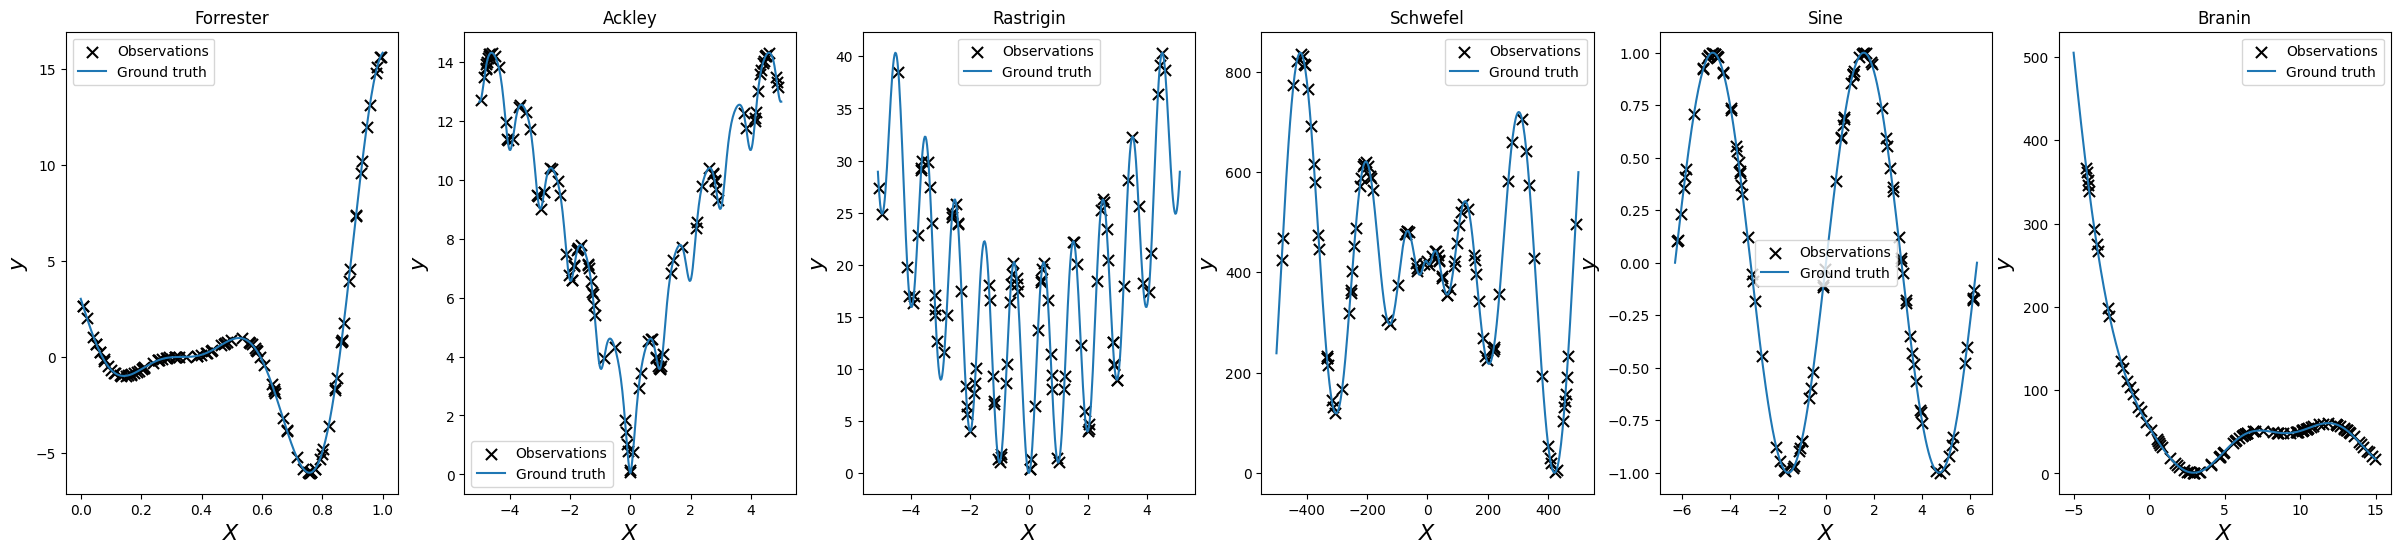

In [ ]:
#X_bounds = np.array([0, 10])
#X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)

fig, ax = plt.subplots(1, len(fn_list), dpi=100, figsize=(30, 6))

y_measured_list = []
ground_truth_list = []
X_measured_list = []
X_unmeasured_list = []

titles = ['Forrester', 'Ackley', 'Rastrigin', 'Schwefel', 'Sine', 'Branin']
x_ranges_list = [np.linspace(0, 1, 400), np.linspace(-5, 5, 400), np.linspace(-5.12, 5.12, 400),
            np.linspace(-500, 500, 400), np.linspace(-2*np.pi, 2*np.pi, 400), np.linspace(-5, 15, 400)]


# Create plots with optimal intervals
for i,(fn, x_range )in enumerate(zip(fn_list, x_ranges_list)):
  X_measured_list.append(np.sort(np.random.uniform(x_range[0], x_range[-1], size=(100,))))
  X_unmeasured_list.append(x_range)
  y_measured = fn(X_measured_list[-1], noise = 0)
  ground_truth = fn(X_unmeasured_list[-1], noise=0)



  ax[i].set_xlabel("$X$", fontsize=16)
  ax[i].set_ylabel("$y$", fontsize=16)
  ax[i].scatter(X_measured_list[-1], y_measured, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
  ax[i].plot(X_unmeasured_list[-1], ground_truth, label='Ground truth')
  ax[i].legend(loc='best')
  ax[i].set_title(titles[i])

  y_measured_list.append(y_measured)
  ground_truth_list.append(ground_truth)

## PySR Fit

In [ ]:
from pysr import PySRRegressor

[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.11.3 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.3-linux-x86_64.tar.gz
             downloaded 0.1 MB of 253.8 MB
             downl

In [ ]:
#fn_list = [rastrigin_1d]

In [ ]:
titles

In [ ]:
models_dict = {}

for i in range(len(titles)):
  # Initialize PySR with some parameters
  print(i, titles[i])

  model = PySRRegressor(
      niterations=5,
      binary_operators=["+", "*", "/", "-"],
      unary_operators=["sin", "cos", "exp", "log"],
      # model_selection="best",
      verbosity=1 )

  model.fit(X_measured_list[i].reshape(-1,1), y_measured_list[i].reshape(-1,1))
  models_dict[titles[i]] = model

0 Forrester


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.066e+01  1.594e+01  y = 0.44854
2           2.019e+01  2.313e-02  y = sin(x₀)
3           1.966e+01  2.629e-02  y = x₀ * x₀
4           1.716e+01  1.360e-01  y = cos(x₀ * -12.952)
7           6.889e+00  3.043e-01  y = exp(log(x₀ * 1.2595) * 12.929)
8           6.668e+00  3.262e-02  y = exp((x₀ * (x₀ - -15.467)) + -13.411)
9           6.246e+00  6.539e-02  y = exp(cos(x₀ / 0.53048) / (x₀ / -9.4458))
12          1.562e+00  4.620e-01  y = x₀ * ((sin(x₀ * -11.046) * (x₀ / 0.086078)) + x₀)
14          1.219e+00  1.239e-01  y = x₀ * (((sin((x₀ * 1.3189) / -0.12015) * x₀) / 0.075199...
                                      ) + x₀)
22          5.355e-01  1.029e-01  y = (x₀ + ((x₀ / (x₀ * -0.1629)) * ((x₀ / -2.2266) / -0.16...
                                      245))) * (x₀ * (x₀ * sin(x₀ / 0.090701)))
───────────────────────────────────

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.676e+01  1.594e+01  y = 8.9507
4           1.388e+01  6.292e-02  y = 8.8378 - cos(x₀)
5           1.288e+01  7.469e-02  y = (x₀ * x₀) / 1.365
6           6.785e+00  6.408e-01  y = (sin(x₀) + x₀) * x₀
7           2.726e+00  9.121e-01  y = (x₀ * (x₀ * 0.44855)) + 4.7728
9           9.302e-01  5.375e-01  y = 15.563 - exp(cos(x₀ / -1.854) + 1.5697)
11          9.302e-01  -0.000e+00  y = (14.602 - exp(cos(x₀ / 1.8541) + 1.5697)) + 0.96153
13          9.290e-01  6.579e-04  y = (14.265 - exp(cos((x₀ + -0.014696) / -1.8597) + 1.5702...
                                      )) + 1.3106
15          8.943e-01  1.904e-02  y = (((x₀ * x₀) * 0.063597) + 13.708) - exp(cos(x₀ / -1.60...
                                      54) + 1.4547)
16          7.193e-01  2.178e-01  y = (cos((-0.15801 / x₀) / 0.45855) + 14.883) - exp(cos(x₀...
               

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.220e+01  1.594e+01  y = 16.47
4           8.889e+01  1.216e-02  y = 15.276 - cos(x₀)
5           5.421e+01  4.945e-01  y = (x₀ * x₀) + 9.8308
7           5.378e+01  4.020e-03  y = 9.8806 - (x₀ * (-0.25641 - x₀))
9           5.374e+01  3.599e-04  y = 10.084 - (x₀ * ((-0.2595 - x₀) * 0.96925))
10          4.973e+01  7.750e-02  y = (x₀ * x₀) + (cos(x₀ * x₀) - -9.9985)
12          4.960e+01  1.303e-03  y = ((cos(x₀ * x₀) + (x₀ * x₀)) - -9.9985) + -0.26571
14          4.823e+01  1.402e-02  y = (x₀ * (x₀ - sin(exp(x₀)))) + (cos(x₀ * x₀) - -9.9985)
16          4.792e+01  3.233e-03  y = (((x₀ / 1.0293) - sin(exp(x₀))) * x₀) + (cos(x₀ * x₀) ...
                                      - -9.6603)
18          4.621e+01  1.814e-02  y = ((x₀ * ((x₀ / 1.6848) - sin(exp(x₀)))) + (cos(x₀ * x₀)...
                                       - -5.4199)) * 1

[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.813e+04  1.594e+01  y = 416.41
4           3.812e+04  9.441e-05  y = cos(x₀) + 416.39
5           2.922e+04  2.659e-01  y = (x₀ * -0.34205) + 410.48
10          2.920e+04  1.164e-04  y = (sin(19.043 - x₀) + 410.49) + (x₀ * -0.34223)
12          2.835e+04  1.474e-02  y = ((x₀ * -0.31647) - (3.8434 / cos(x₀ - 1.7843))) + 416....
                                      31
18          2.792e+04  2.577e-03  y = (((x₀ + -98.445) * (cos(cos(x₀)) * -0.45555)) + 381.54...
                                      ) - (cos(x₀) * (x₀ * -0.044378))
19          2.663e+04  4.740e-02  y = (((x₀ + -5.4179) * (cos(cos(x₀)) * -51.429)) + 197.63)...
                                       - (cos(cos(x₀)) * (x₀ * -50.971))
───────────────────────────────────────────────────────────────────────────────────────────────────
4 Sine


[ Info: Final population:
[ Info: Results saved to:
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


  - outputs/20250211_152042_0yDZFj/hall_of_fame.csv


[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.702e-01  1.594e+01  y = 0.15129
2           4.005e-15  1.594e+01  y = sin(x₀)
4           3.958e-15  5.929e-03  y = sin(x₀) + -8.6107e-09
6           3.928e-15  3.825e-03  y = (x₀ * -1.2817e-09) + sin(x₀)
7           3.910e-15  4.557e-03  y = sin(x₀) + (cos(x₀) * -7.8513e-09)
11          3.846e-15  4.118e-03  y = ((x₀ * (cos(x₀) + 0.95095)) * 1.8626e-09) + sin(x₀)
13          3.845e-15  1.824e-04  y = sin(x₀) + (1.5056e-09 + (-2.7005e-09 / cos(-1.3456 / (...
                                      2.2398 / x₀))))
15          3.745e-15  1.318e-02  y = sin(x₀) + ((cos(x₀) * -1.2512e-08) / sin(sin((x₀ / x₀)...
                                       + -4.8278e-09)))
16          3.702e-15  1.152e-02  y = ((sin(x₀ - (-0.83354 - cos(x₀ + x₀))) * -1.9094e-08) +...
                                       sin(x₀)) * 1
17          3.685e-15  4.4

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.877e+03  1.594e+01  y = 68.97
3           6.405e+03  3.561e-02  y = 74.932 - x₀
4           2.276e+03  1.034e+00  y = exp(1.893 - x₀)
6           6.159e+02  6.536e-01  y = exp(1.7436 - x₀) + 42.899
9           6.042e+02  6.406e-03  y = (exp(1.7456 - x₀) + 42.889) - sin(x₀)
11          5.921e+02  1.012e-02  y = (exp(1.7411 - x₀) + 42.868) - sin(x₀ / 2.1135)
12          2.287e+02  9.510e-01  y = ((x₀ - -0.60902) * 3.8612) + exp((x₀ * -0.48809) + 3.9...
                                      354)
21          2.215e+02  3.582e-03  y = exp((x₀ * -0.6487) + (cos(cos(cos(x₀) - x₀)) + 2.6375)...
                                      ) + ((x₀ + (x₀ - -8.0124)) * 1.5153)
25          2.112e+02  1.192e-02  y = (exp((x₀ * -0.48233) + (cos(cos(cos(x₀ - x₀))) + 3.125...
                                      2)) + (x₀ * (x₀ / 1.1054))) + (x₀ * (5.2

In [ ]:
models_dict

{'Forrester': PySRRegressor.equations_ = [
 	    pick     score                                           equation  \
 	0         0.000000                                                 x0   
 	1         0.096876                                            exp(x0)   
 	2         0.069951                                       x0 * 4.63795   
 	3         0.938529                               -0.2470073 / log(x0)   
 	4         0.026381                            x0 / log(1.049575 / x0)   
 	5         0.027554                 exp(exp(x0) * (log(x0 * x0) + x0))   
 	6         0.032140            exp(exp(x0) * (log(x0 * x0) + x0)) - x0   
 	7         0.002573       exp(exp(x0) * (log(x0 * x0) + x0)) - sin(x0)   
 	8         0.344364  x0 * exp((x0 - -7.223984) * (((3.128613 / x0) ...   
 	9         0.027367  (exp(exp((log(x0) + x0) * x0)) - (x0 + (x0 - -...   
 	10        0.045575  x0 * (((((exp(((x0 * x0) * 3.780356) * x0) * x...   
 	11  >>>>  0.171317  (((((exp((x0 * (x0 + (x0 + x0))) * 

In [ ]:
models_dict[titles[1]]

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          8.9434805   
	1         0.087365                                 8.713875 - cos(x0)   
	2         0.029578                            9.535117 - exp(cos(x0))   
	3         1.651045                     exp(exp(cos(-1.5039654 / x0)))   
	4         0.061208  exp(exp(sin(exp(-2.308103 / (x0 * x0))))) / 0....   
	5         0.071977  (exp(exp(sin(exp(-2.308103 / (x0 * x0))))) + 0...   
	6         0.034324  (-0.17489637 / x0) + (exp(exp(sin(exp(-2.30810...   
	7   >>>>  0.168589  ((-0.17489637 / x0) + (exp(exp(sin(exp(-2.3081...   
	8         0.001868  ((-0.17489637 / x0) + (0.37649226 + (exp(exp(s...   
	9         0.001490  (((-0.17489637 / x0) + 0.37649226) + (exp(exp(...   
	10        0.039747  ((-0.16094972 / x0) + (exp(x0 * ((-2.2494864 /...   
	
	         loss  complexity  
	0   12.575018           1  
	1    9.675693           4  
	2    9.393696           5  
	3    1.802175           6  
	4    1.327047          11  
	5    1.149126          13  
	6    1.072888          15  
	7    0.765807          17  
	8    0.762951          19  
	9    0.760681          21  
	10   0.623581          26  
]

## Parse Equations to Jax Format

In [ ]:
pysr_eqn_dict = {}

for i,title in enumerate(titles):
  equations = models_dict[title].equations_
  equations_data = []
  for index, row in equations.iterrows():
      equation_data = {
          "equation": row['equation'],
          "score": row['loss']
      }
      equations_data.append(equation_data)
  pysr_eqn_dict[f"{title}"] = equations_data


In [ ]:
pysr_eqn_dict

In [ ]:
def convert_to_jax_format(equations_data):
    # Initialize parameter names generator
    def param_names_gen():
        for i in range(26):  # Limit to 26 for simplicity, adjust if more needed
            yield chr(97 + i)  # Generates 'a', 'b', 'c', ...

    modified_equations = []
    param_gen = param_names_gen()

    for item in equations_data:
        equation = item['equation']
        sympy_eq = sp.sympify(equation, evaluate=False)



        # Convert sympy expression to string and replace math functions with jnp equivalents
        jax_eq_str = str(sympy_eq)
        jax_eq_str = jax_eq_str.replace("sin", "jnp.sin").replace("cos", "jnp.cos").replace("exp", "jnp.exp").replace("log", "jnp.log")

        # Replace 'x0' with 'x' for consistency
        jax_eq_str = jax_eq_str.replace("x0", "x")

        modified_equations.append(jax_eq_str)

    return modified_equations

In [ ]:
import sympy as sp

In [ ]:
# iterate through dict:
converted_equations_dict = {}
for i,title in enumerate(titles):
  eqn_list_temp = pysr_eqn_dict[f"{title}"]
  converted_equations_dict[f"{title}"]  = convert_to_jax_format(eqn_list_temp)


In [ ]:
converted_equations_dict

In [ ]:
import re
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def define_functions_and_return_executables_specific_format(modified_equations, title):
    model_list = []
    model_prior_list = []

    # Function to extract numeric constants from the equation
    def find_constants(eq):
        # This regex finds all standalone numbers in the equation
        return set(re.findall(r'\b\d+\.?\d*|\.\d+\b', eq))

    # Generating parameter names sequentially
    def generate_param_names(start='a', count=26):
        for i in range(count):
            yield chr(ord(start) + i)



    for i, eq in enumerate(modified_equations, start=1):
        # Map x0 to x, x1 to y
        eq = eq.replace('x0', 'x').replace('x1', 'y')

        constants = find_constants(eq)

        param_name_gen = generate_param_names()
        param_map = {const: next(param_name_gen) for const in constants}

        # Replace constants in the equation with params dictionary access
        for const, param_name in param_map.items():
            eq = re.sub(r'\b' + const + r'\b', f'params["{param_name}"]', eq)

        # Define the model function
        func_name = f'{title}_guess_{i}'
        model_func_code = f"def {func_name}(x, params):\n    return {eq}\n"

        # Define the prior function with parameters
        prior_name = f'{func_name}_prior'
        prior_func_code = "def " + prior_name + "():\n    return {\n"
        for param_name in param_map.values():
            prior_func_code += f'        "{param_name}": numpyro.sample("{param_name}", dist.Normal(0, 1)),\n'
        prior_func_code += '    }\n'

        # Execute definitions
        print(i, model_func_code)

        try:
              exec(model_func_code, globals())
              exec(prior_func_code, globals())
              model_list.append(eval(func_name))
              model_prior_list.append(eval(prior_name))

        except:
          print(f"error{i}")




        # except Exception as e:
        #     # If there's an error, print the error message and then print "hi".
        #     print(f"Error: {e}")
        #     print("hi")




    return model_list, model_prior_list

# Example modified equations
# modified_equations = [
#     '5.18455',  # Constants will be replaced
#     'jnp.sin(x) - 5.034361',
#     '3.412044 + jnp.log(3.8652146 - 1.1082819) + jnp.sin(jnp.sin(0.08075898 + x) + x)',
# ]

#model_list, model_prior_list = define_functions_and_return_executables_specific_format(modified_equations)
# model_list, model_prior_list = define_functions_and_return_executables_specific_format(converted_equations)

# Now, model_list and model_prior_list contain the actual executable functions.


In [ ]:
titles

In [ ]:
gpax_equations_dict = {}
for i,title in enumerate(titles):
  #if title == 'Rastrigin':
    eqn_list_temp = converted_equations_dict[f"{title}"]
    model_list, model_prior_list = define_functions_and_return_executables_specific_format(eqn_list_temp, title)
    gpax_equations_dict[f"{title}"]  = {"model_list": model_list, "model_prior_list": model_prior_list}

# Gpax on it

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gpax
from scipy.optimize import curve_fit
import numpyro
from copy import deepcopy as dc
import jax.numpy as jnp
import arviz as az

In [ ]:
# For github continuous integration
import os
if os.environ.get("CI_SMOKE"):
    NUM_WARMUP = 10
    NUM_SAMPLES = 10
else:
    NUM_WARMUP = 2000
    NUM_SAMPLES = 2000

In [ ]:
model_list

0 Forrester
1 Ackley
2 Rastrigin
3 Schwefel
4 Sine
handling the functions===> Sine
model number 0


sample: 100%|██████████| 2000/2000 [00:12<00:00, 159.90it/s, 7 steps of size 5.10e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a     -0.04      0.45     -0.04     -0.76      0.68    678.50      1.00
k_length[0]      1.70      0.48      1.63      1.00      2.50    492.21      1.00
    k_scale      1.01      0.68      0.81      0.21      1.77    483.70      1.00
      noise      0.06      0.03      0.06      0.03      0.10    867.03      1.00



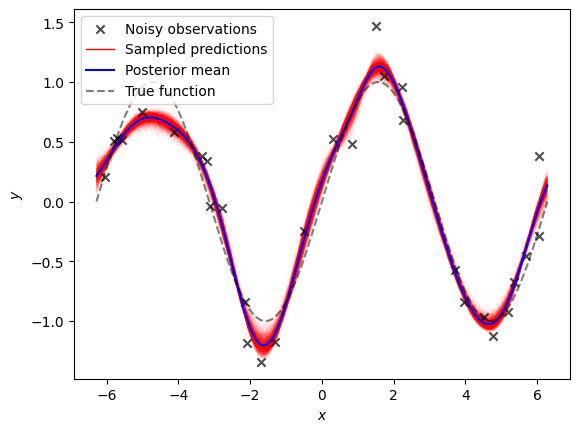

model number 1


sample: 100%|██████████| 2000/2000 [00:11<00:00, 173.22it/s, 7 steps of size 4.59e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      4.82      7.46      2.08      0.06     12.39    466.48      1.00
    k_scale      0.22      0.31      0.11      0.01      0.49    537.26      1.00
      noise      0.06      0.02      0.06      0.03      0.09    472.10      1.00



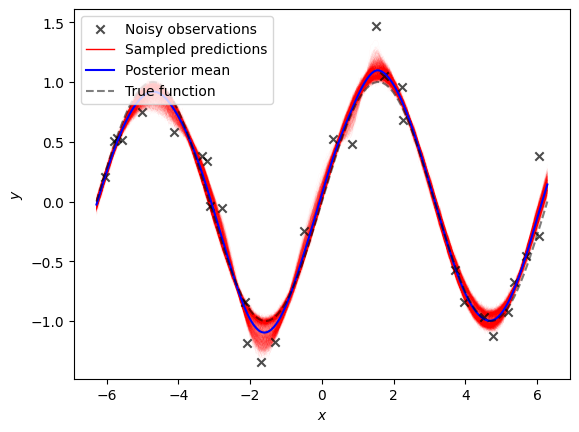

model number 2


sample: 100%|██████████| 2000/2000 [00:15<00:00, 131.77it/s, 7 steps of size 4.38e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      1.03      0.03      1.03      0.98      1.08    462.02      1.02
k_length[0]      4.75      5.87      2.70      0.13     10.83    498.17      1.00
    k_scale      0.26      0.42      0.13      0.01      0.55    477.21      1.00
      noise      0.06      0.02      0.06      0.03      0.09    741.65      1.00



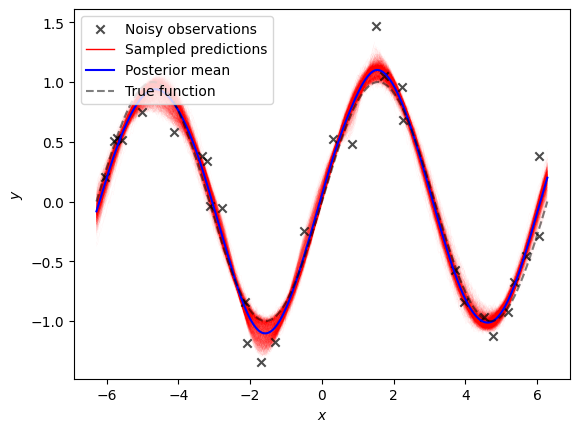

model number 3


sample: 100%|██████████| 2000/2000 [00:17<00:00, 111.47it/s, 7 steps of size 4.21e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      1.02      0.04      1.02      0.96      1.08    536.65      1.00
          b      0.04      0.14      0.03     -0.20      0.26    576.11      1.00
k_length[0]      3.47      4.63      1.78      0.20      8.42    343.16      1.00
    k_scale      0.23      0.31      0.14      0.02      0.50    553.84      1.00
      noise      0.06      0.02      0.06      0.03      0.10    665.99      1.00



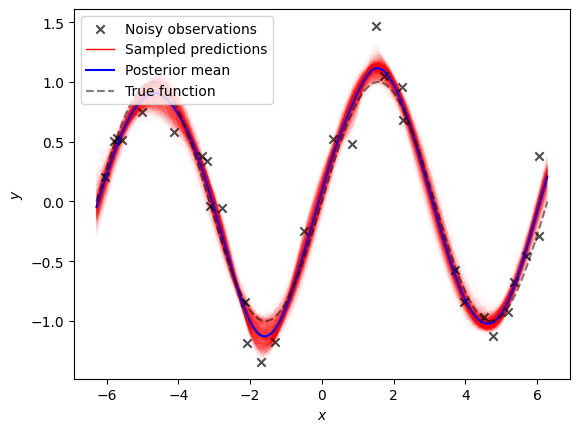

model number 4


sample: 100%|██████████| 2000/2000 [00:38<00:00, 52.24it/s, 7 steps of size 3.66e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a     -1.02      0.04     -1.02     -1.09     -0.96    382.23      1.00
          b     -1.01      0.17     -1.03     -1.24     -0.72    528.17      1.00
          c      0.04      0.15      0.04     -0.23      0.27    710.30      1.00
k_length[0]      3.38      5.16      1.72      0.12      7.72    230.04      1.00
    k_scale      0.23      0.27      0.14      0.01      0.50    432.22      1.00
      noise      0.06      0.02      0.06      0.03      0.09    727.55      1.00



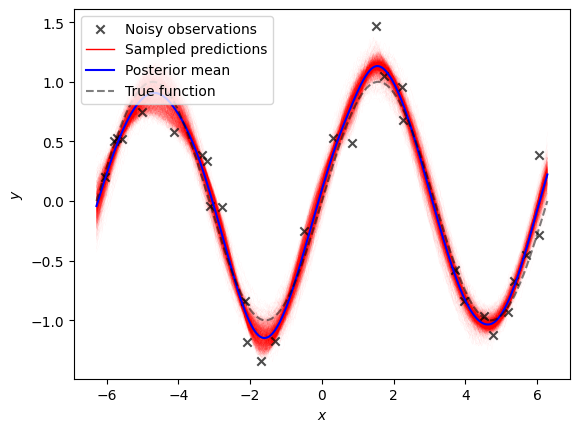

model number 5


sample: 100%|██████████| 2000/2000 [00:15<00:00, 125.80it/s, 7 steps of size 4.80e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.27      0.15      0.27      0.02      0.50    707.64      1.00
          b      1.02      0.03      1.02      0.98      1.06    613.20      1.00
k_length[0]      7.07      9.74      4.81      0.15     14.46    929.59      1.00
    k_scale      0.31      0.38      0.19      0.02      0.70    741.37      1.00
      noise      0.06      0.02      0.05      0.03      0.08    756.83      1.00



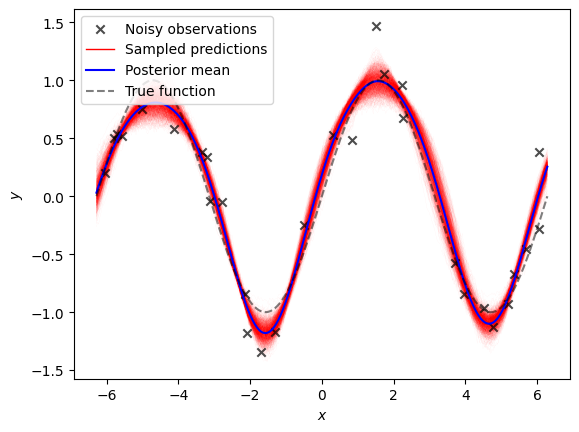

model number 6


sample: 100%|██████████| 2000/2000 [00:47<00:00, 42.42it/s, 31 steps of size 6.92e-02. acc. prob=0.76]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.18      0.17      0.20     -0.09      0.48    190.92      1.00
          b     -0.15      0.99     -0.35     -1.33      1.36      3.98      1.58
          c      1.02      0.03      1.02      0.98      1.06    232.66      1.00
k_length[0]      4.88      5.93      2.80      0.18     12.19    119.32      1.02
    k_scale      0.23      0.35      0.13      0.01      0.51    360.43      1.04
      noise      0.06      0.02      0.05      0.03      0.08    257.06      1.01



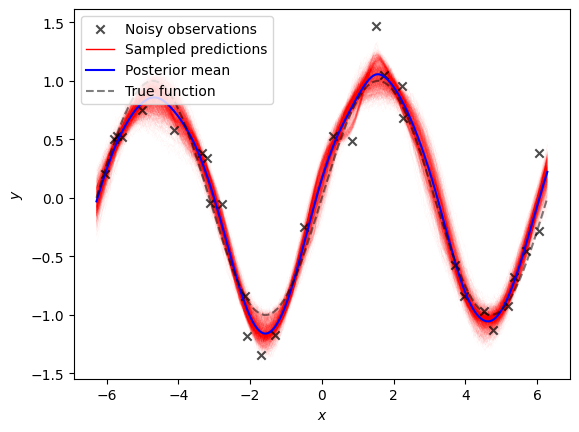

model number 7


sample: 100%|██████████| 2000/2000 [00:16<00:00, 120.33it/s, 7 steps of size 3.79e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.33      0.45      0.36     -0.42      1.05    605.65      1.00
          b      0.50      0.26      0.49      0.05      0.90    609.98      1.00
          c      0.18      0.10      0.18      0.02      0.34    563.29      1.00
k_length[0]     10.35      9.54      7.77      0.59     21.28    424.26      1.00
    k_scale      0.42      0.54      0.27      0.02      0.92    631.76      1.00
      noise      0.05      0.02      0.05      0.03      0.08    582.03      1.00



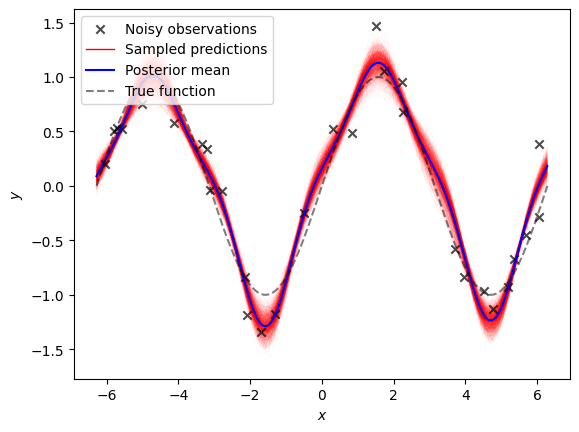

model number 8


sample: 100%|██████████| 2000/2000 [00:19<00:00, 105.15it/s, 7 steps of size 3.66e-01. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.47      0.31      0.47      0.02      0.99    446.23      1.00
          b      0.30      0.45      0.30     -0.41      1.04    391.32      1.00
          c      0.12      0.16      0.15     -0.16      0.36    201.51      1.00
          d      0.00      0.92      0.06     -1.62      1.51    281.31      1.00
k_length[0]      8.10      8.43      5.48      0.37     17.83    406.15      1.01
    k_scale      0.40      0.47      0.25      0.02      0.89    353.58      1.00
      noise      0.06      0.02      0.05      0.03      0.09    449.93      1.00



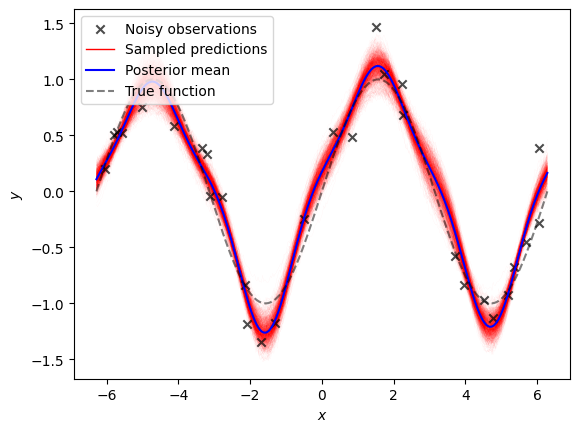

model number 9


sample: 100%|██████████| 2000/2000 [00:17<00:00, 114.84it/s, 15 steps of size 3.87e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.30      0.57      0.35     -0.50      1.30    583.06      1.00
          b      0.24      0.09      0.25      0.10      0.38    524.22      1.00
          c      0.02      0.40      0.02     -0.69      0.63    461.78      1.01
k_length[0]     10.28      9.12      7.89      0.42     21.04    568.92      1.00
    k_scale      0.39      0.42      0.24      0.02      0.87    528.93      1.00
      noise      0.05      0.02      0.05      0.03      0.08    973.50      1.00



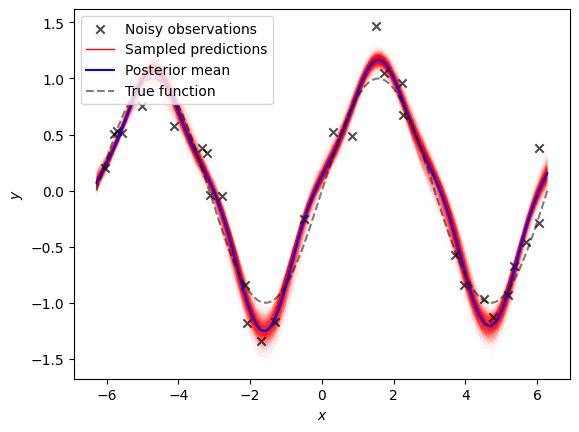

model number 10


sample: 100%|██████████| 2000/2000 [00:19<00:00, 103.68it/s, 7 steps of size 3.77e-01. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.25      0.47      0.27     -0.58      0.94    779.06      1.00
          b      0.20      0.14      0.21     -0.03      0.42    421.65      1.01
          c      0.26      0.97      0.39     -1.45      1.65    417.66      1.00
          d      0.39      0.31      0.39     -0.13      0.89    549.70      1.00
k_length[0]     10.32     11.59      7.24      0.42     21.21    539.67      1.00
    k_scale      0.43      0.50      0.27      0.02      0.93    268.48      1.00
      noise      0.05      0.02      0.05      0.03      0.08    363.97      1.00



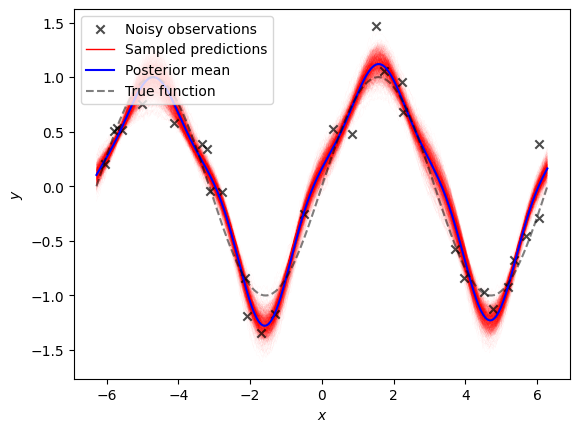

model number 11


sample: 100%|██████████| 2000/2000 [00:33<00:00, 59.60it/s, 31 steps of size 1.52e-01. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.31      0.43      0.33     -0.37      1.00    341.16      1.00
          b      0.49      0.30      0.49      0.02      1.00    420.75      1.00
          c     -0.02      0.33     -0.04     -0.51      0.52     68.78      1.00
          d      0.03      0.88      0.07     -1.29      1.40     68.52      1.00
          e      0.02      1.10      0.06     -1.66      1.77    215.14      1.00
k_length[0]      7.43      7.62      5.10      0.08     16.57    369.24      1.00
    k_scale      0.39      0.52      0.22      0.01      0.88    315.43      1.00
      noise      0.05      0.02      0.05      0.03      0.08    307.83      1.00



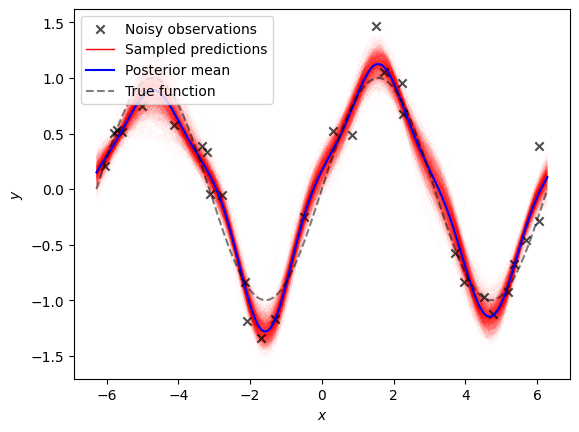

model number 12


sample: 100%|██████████| 2000/2000 [00:39<00:00, 50.09it/s, 15 steps of size 1.89e-01. acc. prob=0.76]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.27      0.10      0.28      0.12      0.44    271.55      1.01
          b      0.18      0.61      0.21     -0.66      1.04    107.26      1.01
          c      0.80      0.62      0.80     -0.26      1.71     23.81      1.07
k_length[0]      8.13      7.63      5.83      0.08     18.12    337.21      1.00
    k_scale      0.25      0.28      0.16      0.01      0.54    431.16      1.00
      noise      0.05      0.02      0.05      0.03      0.07    450.38      1.00



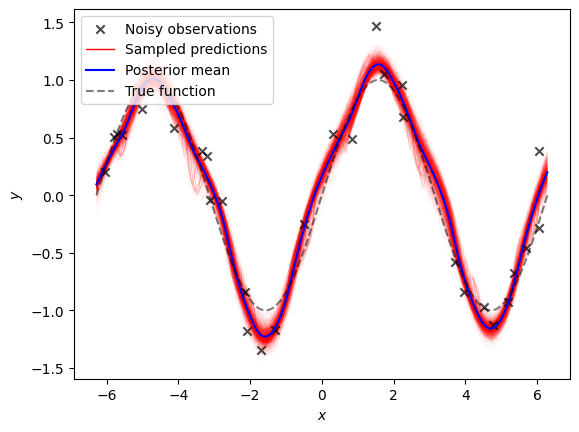

model number 13


sample: 100%|██████████| 2000/2000 [00:32<00:00, 61.77it/s, 15 steps of size 1.31e-01. acc. prob=0.70]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.27      0.12      0.28      0.08      0.44    222.54      1.00
          b      0.81      0.62      0.79      0.29      1.89     71.38      1.01
          c      0.09      0.67      0.18     -0.69      1.16     51.38      1.02
k_length[0]      8.45      8.43      6.05      0.20     18.66    232.68      1.00
    k_scale      0.27      0.37      0.16      0.01      0.60    230.79      1.00
      noise      0.05      0.02      0.05      0.03      0.07    268.62      1.01



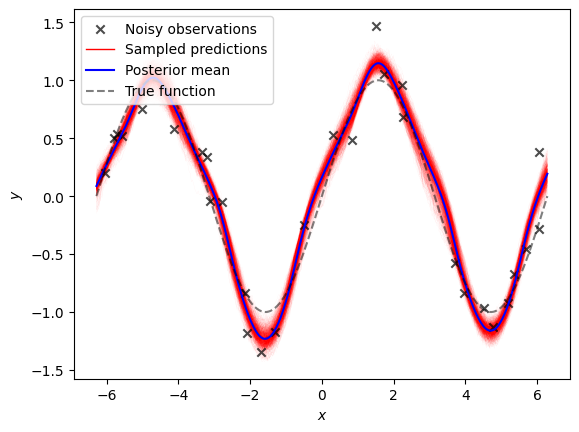

model number 14


sample: 100%|██████████| 2000/2000 [06:08<00:00,  5.43it/s, 31 steps of size 4.70e-03. acc. prob=0.54]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a     -0.50      0.00     -0.50     -0.50     -0.49     29.14      1.01
          b      0.16      0.12      0.17     -0.02      0.36     55.92      1.02
k_length[0]      6.85      7.77      3.26      0.10     15.95     30.63      1.00
    k_scale      0.29      0.40      0.13      0.01      0.68     26.19      1.02
      noise      0.06      0.02      0.05      0.03      0.09     28.15      1.04



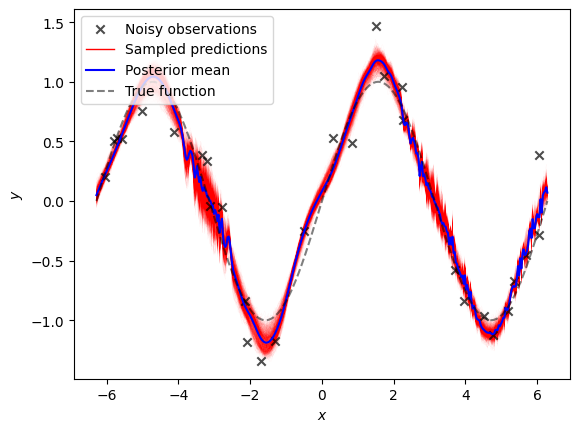

5 Branin


In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys()

for i,title in enumerate(titles):

  #Remove the line below if want to analyze all fucntions
  print(i, title)
  if title == 'Schwefel': #'Sine':

    print("handling the functions===>", title)
    model_list = gpax_equations_dict[f"{title}"]["model_list"]
    model_prior_list = gpax_equations_dict[f"{title}"]["model_prior_list"]

    for j,(m, mp) in enumerate(zip(model_list,model_prior_list)):
      # Initialize model
      print("model number", j)
      gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=m, mean_fn_prior=mp)

      # Run MCMC to obtain posterior samples
      gp_model.fit(rng_key, X_measured_list[i], y_measured_list[i], num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)

      # Get GP prediction
      posterior_mean, f_samples = gp_model.predict(rng_key_predict, X_unmeasured_list[i], n=200)

      # Plot results
      _, ax = plt.subplots(dpi=100)
      ax.set_xlabel("$x$")
      ax.set_ylabel("$y$")
      ax.scatter(X_measured_list[i], y_measured_list[i], marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
      for y1 in f_samples:
          ax.plot(X_unmeasured_list[i], y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
      l, = ax.plot(X_unmeasured_list[i], f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
      ax.plot(X_unmeasured_list[i], posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')

      ax.plot(X_unmeasured_list[i], ground_truth_list[i], c='k', linestyle='--', label='True function', alpha=0.5)
      ax.legend(loc='upper left')
      l.set_alpha(0)
      plt.show()


In [ ]:


# # Plot results
# truefunc = func(X_unmeasured)
# seed_points = 15
# plt.figure(dpi=100)
# plt.scatter(X_measured[seed_points:], y_measured[seed_points:], c=jnp.arange(1, len(X_measured[seed_points:])+1),
#             cmap='viridis', label="Sampled points", zorder=1)
# cbar = plt.colorbar(label="Exploration step")
# cbar_ticks = np.arange(2, len(X_measured[seed_points:]) + 1, 2)
# cbar.set_ticks(cbar_ticks)
# plt.scatter(X_measured[:seed_points], y_measured[:seed_points], marker='x', s=64,
#             c='k', label="Seed points", zorder=1)
# plt.plot(X_unmeasured, truefunc, c='k', label='True function', zorder=0)
# plt.plot(X_unmeasured, posterior_mean, '--', c='red', label='Posterior mean', zorder=0)

# plt.fill_between(X_unmeasured, posterior_mean - f_samples.std((0,1)), posterior_mean + f_samples.std((0,1)),
#                         color='r', alpha=0.2, label="Model uncertainty", zorder=0)
# plt.xlabel("$x$", fontsize=12)
# plt.ylabel("$y$", fontsize=12)
# plt.legend(fontsize=9)
# plt.show()

# Next Active learning